In [1]:
import pickle 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import joblib
import warnings
warnings.filterwarnings("ignore")

In [2]:
 
regr1 = joblib.load(filename="CFmodel.pkl")

In [4]:
params = np.array([[ 0.20277665,  0.39292402,  1.0109525 , 12.        ,  0.83956589,
         0.12718844],
       [ 0.47617116,  0.72013882,  0.58040636, 16.875     ,  0.47323503,
         0.09520141],
       [ 0.67344808,  0.77307396,  0.56856087, 43.        ,  0.27520239,
         0.08328608]])
paramsSTD = np.array([[7.76736005e-02, 1.22145680e-01, 1.90630379e-01, 3.46410162e+00,
        2.41425015e-01, 2.85436853e-02],
       [2.67305219e-01, 3.26664761e-01, 1.04889753e-01, 8.47580590e+00,
        1.35655301e-01, 2.02912497e-02],
       [3.74046635e-01, 3.03003025e-01, 1.98149077e-01, 3.70135110e+01,
        1.16833618e-01, 2.74512321e-02]])

In [5]:
def relu(x):
    if x<0:
        res = 0
    else:
        res = x
    return res

def process_TTC(x):
    if (x<0) & (x>-10):
        res = abs(x)
    elif x<-10:
        res = 10
    else:
        res = 20
    return res
def process_headway(x):
    if x>100:
        res = 100
    else:
        res = x
    return res

In [6]:
calbration_start_point = 630
calbration_end_point = 330
val_base_start_point = 330
val_base_end_point = 30
val_crash_start_point = 30

0.03577327298496267
Jump Size:  0.15106117212342463
Index([-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')


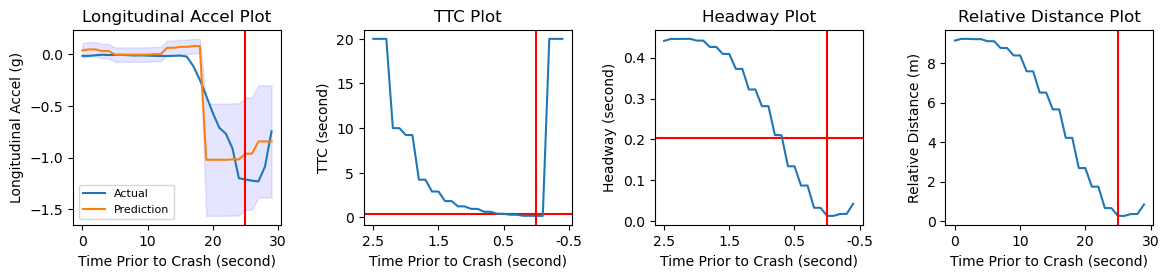

In [9]:

data_utilized = pd.read_csv("TripData-DEMO.csv").dropna()
data_utilized.index = np.arange(data_utilized.shape[0])
 
severity = "I - Most Severe"
if severity == "I - Most Severe":
    param_headway,param_ttc,param_jump,std_jump = params[0][0],params[0][1],params[0][4],paramsSTD[0][4]
if severity == "II - Police-reportable Crash":
    param_jump,param_ttc,param_headway,std_jump = params[1][0],params[1][1],params[1][4],paramsSTD[1][4]
if severity == "III  - Minor Crash":
    param_jump,param_ttc,param_headway,std_jump = params[2][0],params[2][1],params[2][4],paramsSTD[2][4]
    
data_utilizedFINAL = data_utilized[['x_pos_processed','y_pos_processed', 
                             'x_vel_processed', 'y_vel_processed',"x_acc_estimated","speed","t"]].dropna()
prediction = regr1.predict(data_utilized[['x_pos_processed','y_pos_processed', 
                             'x_vel_processed', 'y_vel_processed',"x_acc_estimated","speed"]].dropna())[:-1]
gt = data_utilized.iloc[data_utilized[['x_pos_processed','y_pos_processed', 
                             'x_vel_processed', 'y_vel_processed',"x_acc_estimated","speed"]].dropna().index]["acc_x"][1:]
 
start_times = np.array(([1130184., 1132418.]))
end_time = np.array([1134496.])

threshold = (data_utilized["t"] - start_times[1]).abs().argmin()
threshold_ = (data_utilized["t"] - end_time).abs().argmin()
ttcPrior = (data_utilizedFINAL["x_pos_processed"]/data_utilizedFINAL["x_vel_processed"]).apply(lambda xxx:process_TTC(xxx))[:-1].values
headwayPrior = (data_utilizedFINAL["x_pos_processed"]/data_utilizedFINAL["speed"]).apply(lambda xxx:process_headway(xxx))[:-1].values
#print (headwayPrior[threshold-10:threshold].min(),ttcPrior[threshold-10:threshold].min(),prediction[threshold-10:threshold].min())
klx = (gt-prediction)[threshold-calbration_start_point:threshold-calbration_end_point]
rvx = (klx**2).sum()
bpv_x = np.sqrt(2/np.pi)*((klx.dropna().abs().values[1:]) * (klx.dropna().abs().values[:-1])).sum()
sigma = np.sqrt(bpv_x/(klx.shape[0]))
print (sigma)
trigger = pd.Series(list(map(lambda xx:1 if   (ttcPrior[xx]<param_ttc) and (headwayPrior[xx]<param_headway) 
                         else 0,range(len(prediction)))))
predictionNEW = pd.Series(list(map(lambda xx:prediction[xx] - param_jump if   (ttcPrior[xx]<param_ttc) or (headwayPrior[xx]<param_headway) 
                         else prediction[xx],range(len(prediction)))))
print ("Jump Size: ", relu(rvx-bpv_x))
indexes = (predictionNEW - prediction).abs()[(predictionNEW - prediction).abs()>0].index
print (indexes[(indexes>threshold-20) & (indexes<threshold+20)]-threshold)
trigger = pd.Series(list(map(lambda xx:1 if   (ttcPrior[xx]<param_ttc) or (headwayPrior[xx]<param_headway) 
                         else 0,range(len(prediction)))))
start_point = 25
trigger_val = trigger[threshold-start_point:threshold+5]
#Should be cconflict with lead vehicle. no other tasks 
plt.figure(figsize=(12,3))
plt.subplot(141)
plt.plot(gt.rolling(5).mean()[threshold-start_point:threshold+5].values,label="Actual")
plt.plot(np.array(predictionNEW)[threshold-start_point:threshold+5],label="Prediction")
plt.legend(fontsize=8,loc=3)
plt.fill_between(np.arange(gt[threshold-start_point:threshold+5].values.shape[0]), 
                 predictionNEW[threshold-start_point:threshold+5]-1.96*sigma-1.96*std_jump*trigger_val, 
                 predictionNEW[threshold-start_point:threshold+5]+1.96*sigma+1.96*std_jump*trigger_val, color='b', alpha=.1)
plt.ylabel("Longitudinal Accel (g)")
plt.title("Longitudinal Accel Plot")
#plt.xticks(np.arange(0,61,20),5.5-np.arange(0,6.1,2))
plt.xlabel("Time Prior to Crash (second)")
plt.axvline(start_point,c="red")


#plt.xticks(np.arange(0,31,10),2.5-np.arange(0,3.1,1))
plt.xlabel("Time Prior to Crash (second)")
plt.subplot(142)
plt.axhline(param_ttc,c="red")
plt.plot(ttcPrior[threshold-start_point:threshold+5])
plt.xticks(np.arange(0,31,10),2.5-np.arange(0,3.1,1))
plt.axvline(25,c="red")

plt.xlabel("Time Prior to Crash (second)")
plt.title("(b)")
plt.ylabel("TTC (second)")
plt.title("TTC Plot")
plt.subplot(143)
plt.axhline(param_headway,c="red")
plt.plot(headwayPrior[threshold-start_point:threshold+5])
plt.xticks(np.arange(0,31,10),2.5-np.arange(0,3.1,1))
plt.xlabel("Time Prior to Crash (second)")
plt.axvline(25,c="red")
plt.title("(e)")
plt.ylabel("Headway (second)")
plt.title("Headway Plot")
plt.subplot(144)
plt.plot(data_utilizedFINAL["x_pos_processed"][threshold-start_point:threshold+5].values)
plt.tight_layout(pad=1.5)
plt.xlabel("Time Prior to Crash")
plt.title("Relative Distance Plot")
plt.xlabel("Time Prior to Crash (second)")
plt.ylabel("Relative Distance (m)")
plt.axvline(25,c="red")
  

#plt.axvline(threshold,c="red")

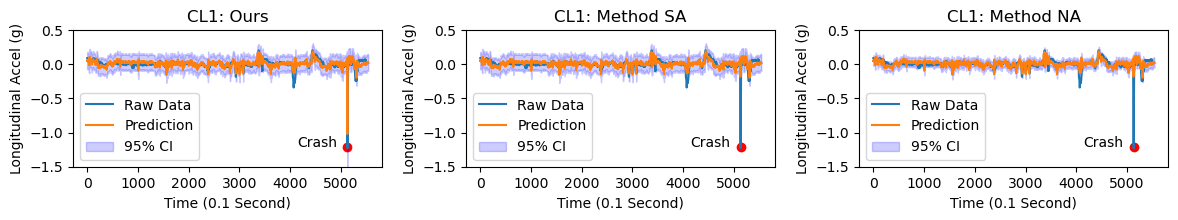

In [11]:
 
plt.figure(figsize=(12,6))
no =  1005
data_utilized = pd.read_csv("TripData-DEMO.csv").dropna()
data_utilized.index = np.arange(data_utilized.shape[0])
file_id = data_utilized["file_id"].iloc[0]

 
if severity == "I - Most Severe":
    param_headway,param_ttc,param_jump,std_jump = params[0][0],params[0][1],params[0][4],paramsSTD[0][4]
if severity == "II - Police-reportable Crash":
    param_jump,param_ttc,param_headway,std_jump = params[1][0],params[1][1],params[1][4],paramsSTD[1][4]
if severity == "III  - Minor Crash":
    param_jump,param_ttc,param_headway,std_jump = params[2][0],params[2][1],params[2][4],paramsSTD[2][4]
    
data_utilizedFINAL = data_utilized[['x_pos_processed','y_pos_processed', 
                             'x_vel_processed', 'y_vel_processed',"x_acc_estimated","speed","t"]].dropna()
prediction = regr1.predict(data_utilized[['x_pos_processed','y_pos_processed', 
                             'x_vel_processed', 'y_vel_processed',"x_acc_estimated","speed"]].dropna())[:-1]
gt = data_utilized.iloc[data_utilized[['x_pos_processed','y_pos_processed', 
                             'x_vel_processed', 'y_vel_processed',"x_acc_estimated","speed"]].dropna().index]["acc_x"][1:]
 
start_times = np.array(([1130184., 1132418.]))
end_time = np.array([1134496.])
threshold = (data_utilized["t"] - start_times[1]).abs().argmin()
threshold_ = (data_utilized["t"] - end_time).abs().argmin()
ttcPrior = (data_utilizedFINAL["x_pos_processed"]/data_utilizedFINAL["x_vel_processed"]).apply(lambda xxx:process_TTC(xxx))[:-1].values
headwayPrior = (data_utilizedFINAL["x_pos_processed"]/data_utilizedFINAL["speed"]).apply(lambda xxx:process_headway(xxx))[:-1].values
#print (headwayPrior[threshold-10:threshold].min(),ttcPrior[threshold-10:threshold].min(),prediction[threshold-10:threshold].min())

bpv_x = np.sqrt(2/np.pi)*((klx.dropna().abs().values[1:]) * (klx.dropna().abs().values[:-1])).sum()
sigma = 0.06
trigger = pd.Series(list(map(lambda xx:1 if   (ttcPrior[xx]<param_ttc) and (headwayPrior[xx]<param_headway) 
                         else 0,range(len(prediction)))))
predictionNEW = pd.Series(list(map(lambda xx:prediction[xx] - param_jump if   (ttcPrior[xx]<param_ttc) and (headwayPrior[xx]<param_headway) 
                         else prediction[xx],range(len(prediction)))))
 
indexes = (predictionNEW - prediction).abs()[(predictionNEW - prediction).abs()>0].index
 
trigger = pd.Series(list(map(lambda xx:1 if   (ttcPrior[xx]<param_ttc) and (headwayPrior[xx]<param_headway) 
                         else 0,range(len(prediction)))))
trigger_val = trigger
#Should be cconflict with lead vehicle. no other tasks 
plt.subplot(331)
plt.scatter(threshold,gt.rolling(5).mean().values[threshold],c="red")
plt.text(threshold-200,gt.rolling(5).mean().values[threshold],"Crash",
        horizontalalignment='right', )
plt.plot(gt.rolling(5).mean().values,label="Raw Data")
plt.plot(np.array(predictionNEW),label="Prediction")
plt.legend(fontsize=10,loc=6)
plt.fill_between(np.arange(gt.values.shape[0]), 
                 predictionNEW-1.96*sigma-1.96*std_jump*trigger_val, 
                 predictionNEW+1.96*sigma+1.96*std_jump*trigger_val, color='b', alpha=.2,
                 label="95% CI")
plt.legend(fontsize=10,loc=3)
plt.ylabel("Longitudinal Accel (g)")
plt.title("CL1: Ours")
plt.ylim(-1.5,0.5)
plt.yticks([-1.5,-1,-0.5,0,0.5])
plt.xlabel("Time (0.1 Second)")
plt.subplot(332)
plt.scatter(threshold,gt.rolling(5).mean().values[threshold],c="red")
plt.text(threshold-200,gt.rolling(5).mean().values[threshold],"Crash",
        horizontalalignment='right',)
plt.plot(gt.rolling(5).mean().values,label="Raw Data")
plt.plot(np.array(prediction),label="Prediction")

plt.fill_between(np.arange(gt.values.shape[0]), 
                 np.array(prediction)-1.96*sigma, 
                 np.array(prediction)+1.96*sigma, color='b', alpha=.2,label="95% CI")
plt.legend(fontsize=10,loc=3)
plt.title("CL1: Method SA")
 
plt.ylabel("Longitudinal Accel (g)")
plt.ylim(-1.5,0.5)
 
plt.xlabel("Time (0.1 Second)")
plt.subplot(333)
 
plt.plot(gt.rolling(5).mean().values,label="Raw Data")
plt.plot(np.array(prediction),label="Prediction")
plt.fill_between(np.arange(gt.values.shape[0]), 
                 np.array(prediction)-1.96*klx.std(), 
                 np.array(prediction)+1.96*klx.std(), color='b', alpha=.2,label="95% CI")
plt.legend(fontsize=10,loc=3)
plt.title("CL1: Method NA")
plt.ylabel("Longitudinal Accel (g)")
plt.ylim(-1.5,0.5)
plt.scatter(threshold,gt.rolling(5).mean().values[threshold],c="red")
plt.text(threshold-200,gt.rolling(5).mean().values[threshold],"Crash",horizontalalignment='right',
        )
 
plt.xlabel("Time (0.1 Second)")
plt.tight_layout(pad=1.5)

 
 